<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/variational_autoencoders/vanilla_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper: [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)

Reference: [An Introduction to Variational Autoencoders](https://arxiv.org/pdf/1906.02691.pdf)

In [42]:
import torch.nn as nn
import torch
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torchvision.utils import make_grid

In [43]:
lr = 1e-3
b1 = 0.5
b2 = 0.999
batch_size = 128
n_epochs = 30
hidden_dim = 400
latent_dim = 2
channels = 1
img_size = 28
img_shape = (channels,img_size,img_size)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [44]:
class Encoder(nn.Module):
    def __init__(self,):
        super(Encoder,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)),hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim,int(hidden_dim // 2)),
            nn.LeakyReLU()
        )
        self.mu = nn.Linear(int(hidden_dim // 2),latent_dim)
        self.log_var = nn.Linear(int(hidden_dim // 2),latent_dim)

    def forward(self,x):
        x_flat = x.view(x.size(0),-1)
        out = self.model(x_flat)
        mu = self.mu(out)
        log_var = self.log_var(out)
        return mu,log_var

In [45]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim,int(hidden_dim // 2)),
            nn.LeakyReLU(),
            nn.Linear(int(hidden_dim // 2),hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim,int(np.prod(img_shape))),
            nn.Sigmoid()
        )
    def forward(self,z):
        out = self.model(z)
        return out

In [46]:
class Vanilla_VAE(nn.Module):
    def __init__(self):
        super(Vanilla_VAE,self).__init__()

        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)

    def forward(self,x):
        mu,log_var = self.encoder(x)
        z = self.reparameterize(mu,log_var)
        x_hat = self.decoder(z)
        return x_hat,mu ,log_var

    def reparameterize(self,mu,log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std).to(device)
        return mu + eps * std


loss function

In [47]:
model = Vanilla_VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = lr ,betas = (b1,b2))

In [48]:
loss_fn = nn.BCELoss(reduction = 'sum')
def loss_function(x,x_hat,mean,log_var):
    reconstructed_loss = loss_fn(x_hat,x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstructed_loss + kl_divergence

In [49]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = datasets.MNIST('./root',train = True,download = True,transform = transform)
train_dataloader = DataLoader(train_dataset,shuffle = True,batch_size = batch_size)

test_dataset = datasets.MNIST('./root',train = False, download = True, transform = transform)
test_dataloader = DataLoader(test_dataset,shuffle = False,batch_size = batch_size)

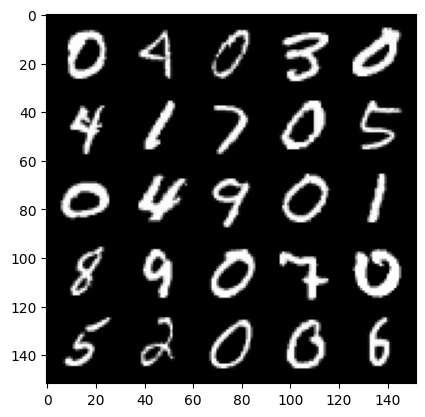

In [50]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
images,labels = next(iter(train_dataloader))
show_tensor_images(images)

In [51]:
from tqdm import tqdm

In [52]:
total_loss = []
for epoch in range(n_epochs):
    for (images,labels) in tqdm(train_dataloader):
        real_imgs = images.to(device)
        real_imgs = real_imgs.view(-1,784)
        optimizer.zero_grad()
        reconstructed_imgs,mu,log_var = model(real_imgs)
        loss = loss_function(real_imgs,reconstructed_imgs,mu,log_var)
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item()/len(real_imgs):.4f}')



100%|██████████| 469/469 [00:33<00:00, 14.01it/s]


Epoch [1/30], Loss: -50641.3854


100%|██████████| 469/469 [00:32<00:00, 14.31it/s]


Epoch [2/30], Loss: -51604.3073


100%|██████████| 469/469 [00:30<00:00, 15.22it/s]


Epoch [3/30], Loss: -46268.8854


100%|██████████| 469/469 [00:31<00:00, 14.79it/s]


Epoch [4/30], Loss: -49333.0521


100%|██████████| 469/469 [00:31<00:00, 15.03it/s]


Epoch [5/30], Loss: -49774.2292


100%|██████████| 469/469 [00:31<00:00, 15.03it/s]


Epoch [6/30], Loss: -49534.9479


100%|██████████| 469/469 [00:31<00:00, 14.73it/s]


Epoch [7/30], Loss: -49960.4531


100%|██████████| 469/469 [00:31<00:00, 15.07it/s]


Epoch [8/30], Loss: -50708.8177


100%|██████████| 469/469 [00:34<00:00, 13.78it/s]


Epoch [9/30], Loss: -53340.1927


100%|██████████| 469/469 [00:30<00:00, 15.33it/s]


Epoch [10/30], Loss: -51159.3490


100%|██████████| 469/469 [00:31<00:00, 14.85it/s]


Epoch [11/30], Loss: -49040.5729


100%|██████████| 469/469 [00:30<00:00, 15.17it/s]


Epoch [12/30], Loss: -52542.0469


100%|██████████| 469/469 [00:31<00:00, 15.08it/s]


Epoch [13/30], Loss: -50258.6354


100%|██████████| 469/469 [00:34<00:00, 13.68it/s]


Epoch [14/30], Loss: -50774.1875


100%|██████████| 469/469 [00:30<00:00, 15.24it/s]


Epoch [15/30], Loss: -50373.1823


100%|██████████| 469/469 [00:33<00:00, 14.16it/s]


Epoch [16/30], Loss: -49378.6354


100%|██████████| 469/469 [00:31<00:00, 14.67it/s]


Epoch [17/30], Loss: -46994.9896


100%|██████████| 469/469 [00:31<00:00, 14.80it/s]


Epoch [18/30], Loss: -48614.6406


100%|██████████| 469/469 [00:31<00:00, 14.86it/s]


Epoch [19/30], Loss: -49010.1094


100%|██████████| 469/469 [00:34<00:00, 13.73it/s]


Epoch [20/30], Loss: -48436.7135


100%|██████████| 469/469 [00:30<00:00, 15.37it/s]


Epoch [21/30], Loss: -48900.6354


100%|██████████| 469/469 [00:31<00:00, 15.02it/s]


Epoch [22/30], Loss: -47547.1198


100%|██████████| 469/469 [00:31<00:00, 14.96it/s]


Epoch [23/30], Loss: -48077.4479


100%|██████████| 469/469 [00:32<00:00, 14.37it/s]


Epoch [24/30], Loss: -45108.7448


100%|██████████| 469/469 [00:32<00:00, 14.28it/s]


Epoch [25/30], Loss: -47467.4479


100%|██████████| 469/469 [00:31<00:00, 15.10it/s]


Epoch [26/30], Loss: -45333.6927


100%|██████████| 469/469 [00:32<00:00, 14.42it/s]


Epoch [27/30], Loss: -45438.8906


100%|██████████| 469/469 [00:30<00:00, 15.16it/s]


Epoch [28/30], Loss: -45143.6406


100%|██████████| 469/469 [00:31<00:00, 14.92it/s]


Epoch [29/30], Loss: -48302.3594


100%|██████████| 469/469 [00:31<00:00, 14.81it/s]

Epoch [30/30], Loss: -46563.1458


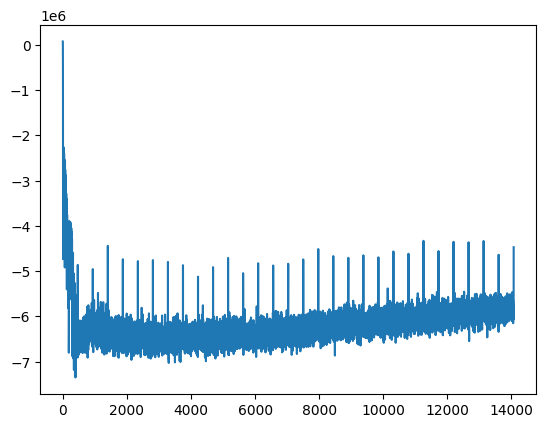

In [53]:
plt.plot(range(len(total_loss)),total_loss)

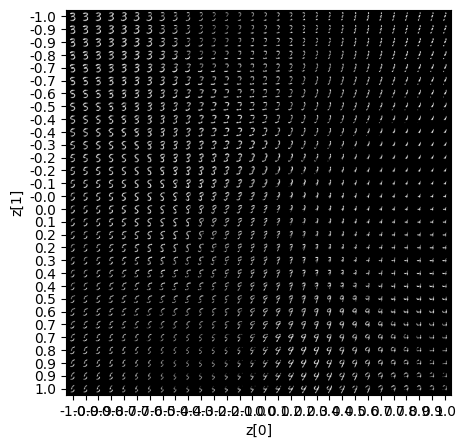

In [61]:
def plot_latent_space(vae, n=30, figsize=5):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]]).float().to(device)# Assuming vae.device is set correctly
            x_decoded = vae.decoder(z_sample)
            digit = x_decoded.view(digit_size, digit_size).cpu().detach().numpy()
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    # plt.xticks(pixel_range, sample_range_x)
    # plt.yticks(pixel_range, sample_range_y)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y[::-1])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(model)

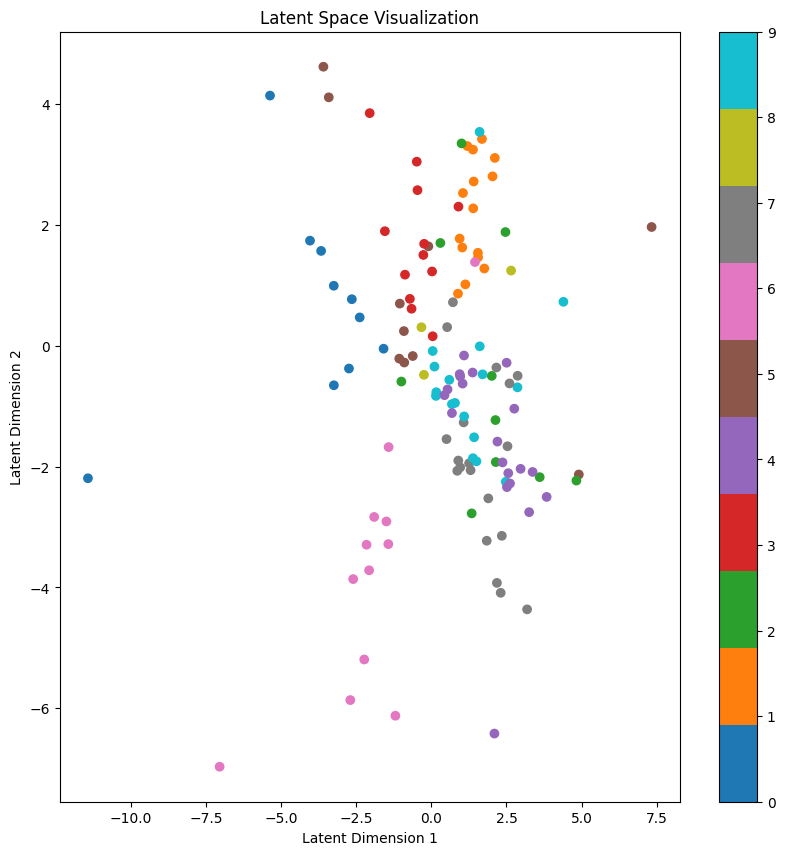

In [58]:
def plot_latent_space(vae, test_loader, n=30, figsize=10):
    vae.eval()
    with torch.no_grad():
        data, labels = next(iter(test_loader))
        data = data.view(-1, 784).to(device)
        reconstructed_data, mean, logvar = vae(data)
        z = vae.reparameterize(mean, logvar)

        plt.figure(figsize=(figsize, figsize))
        z=z.cpu()
        plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
        plt.colorbar()
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.title('Latent Space Visualization')
        plt.show()
plot_latent_space(model,test_dataloader)